In [2]:
using LazySets, Plots

In [1]:
B = rand(BallInf)
G = rand(2, 2)
c = rand(2)
Z = B * G + c

UndefVarError: UndefVarError: BallInf not defined

In [ ]:
plot(B, lab="B")
plot!(Z, lab="Z")

In [ ]:
plot

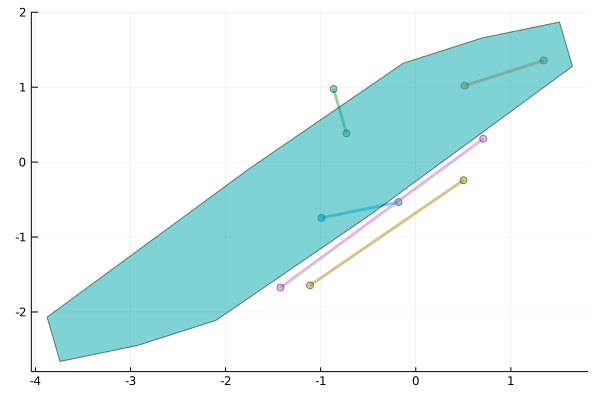

In [12]:
L = [rand(LineSegment) for _ in 1:5]
plot(L, lw=3.0)
plot!(reduce(+, L))

In [3]:
plot(reduce(+, [rand(LineSegment) for _ in 1:5])

LoadError: syntax: incomplete: premature end of input

In [ ]:
- `*` and `LinearMap`: lazy
- `linear_map` : concrete

Lo mismo para:

- `+` and `MinkowskiSum`: lazy
- `minkowski_sum` : concrete

etc, etc.

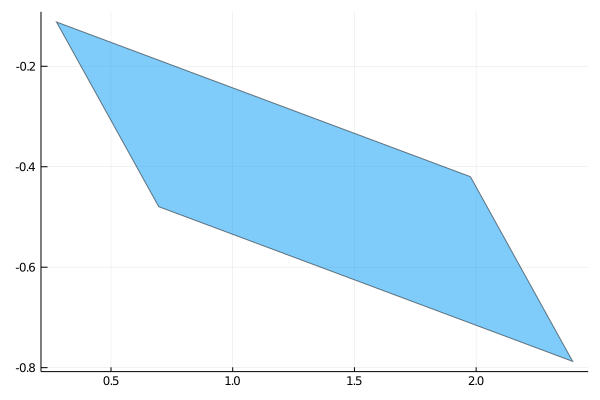

In [14]:
Z1 = rand(Zonotope)
Z2 = rand(Zonotope)

plot()
plot(intersection(Z1, Z2))

In [41]:
using LazySets, Optim, Plots

In [53]:
H = rand(Hyperplane, dim=6);
Z = rand(Zonotope, dim=6);
X = Z ∩ H

Intersection{Float64,Zonotope{Float64,Array{Float64,1},Array{Float64,2}},Hyperplane{Float64,Array{Float64,1}}}(Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([1.7463169413290704, 1.7687303556177605, 0.6514830920677465, -0.7670569296949337, 0.5830171741474598, 0.4147227528951568], [1.0679412132607355 0.6986697623827209 … -0.044737404322871384 1.2247971011650327; -0.7647365403051637 0.8197150558930362 … -0.8862776746256823 -1.8450570285835788; … ; -0.9253253235957564 -1.073741322256792 … 0.8794207268262141 -0.30593798006225953; -1.2285308663506802 -0.9799025190229519 … -0.33865438518476804 -1.497393023011229]), Hyperplane{Float64,Array{Float64,1}}([0.0018589636138475253, -0.04790616580175086, -0.25422174985409135, -1.0867290602106305, -1.1219938944589487, 3.2560590681369286], 0.9554388990120184), LazySets.IntersectionCache(-1))

In [54]:
Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

plot(Projection(Xbox, [1,2]), lab="Xbox")
plot!(Projection(Xoct, [1,2]), lab="Xoct")

Aqui usamos que:

$$
\rho(d, X \cap Y) \leq \min\{ \rho(d, X), \rho(d, Y)\}
$$

La cota *no es tight* en general.

In [56]:
H = rand(Hyperplane, dim=2);
Z = rand(Zonotope, dim=2);
X = Z ∩ H

Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

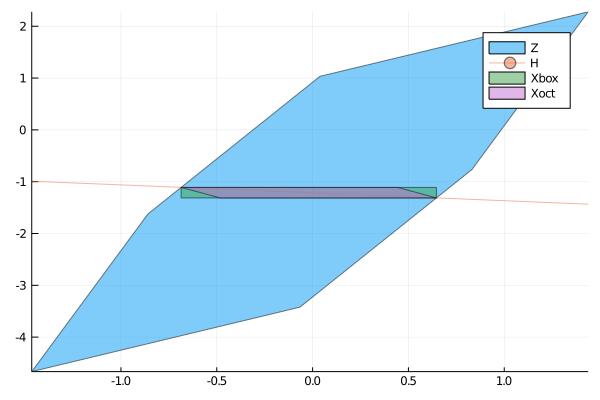

In [58]:
plot(Z, lab="Z")
plot!(H, lab="H")
plot!(Xbox, lab="Xbox")
plot!(Xoct, lab="Xoct")

## Reduccion a intersecciones en el plano

In [220]:
using LazySets: center

function _above(vec)
    return vec[2] > 0 || (vec[2] == 0 && vec[1] > 0)
end

# returns the support vector of Z ∩ L along direction (0, 1)
function bound_intersect_2D(Z::AbstractZonotope, L::Line2D)
    c = center(Z)
    P = copy(c)
    G = genmat(Z)
    r = ngens(Z)
    g(x) = view(G, :, x)
    for i = 1:r
        gi = g(i)
        if !_above(gi)
            gi .= -gi
        end
        P .= P - gi
    end
    G = sortslices(G, dims=2, by=x->atan(x[2], x[1])) # sort gens
    if P[1] < L.b
        G .= G[:,end:-1:1]
    end
    j = 1
    while isempty(intersection(LineSegment(P, P+2g(j)), L)) # TODO use `isdisjoint`
        P .= P + 2g(j)
        j += 1
        if j > size(G, 2)
            error("xxxxx")
        end
    end
    vec = intersection(LineSegment(P, P+2g(j)), L)
    return element(vec)[2]
end

# slower using hrep
function bound_intersect_2D_slow(Z::AbstractZonotope, L::Line2D)
    X = intersection(Z, L)
    return ρ([0.0, 1.0], X)
end

bound_intersect_2D_slow (generic function with 1 method)

In [142]:
G = rand(2, 6)
view(G, :, 4)

2-element view(::Array{Float64,2}, :, 4) with eltype Float64:
 0.7867563221518838
 0.7729765091378125

In [170]:
using LazySets.Approximations: AbstractDirections

function _overapproximate_projection_method(X::Intersection{N, <:AbstractZonotope{N}, <:Hyperplane{N}},
                                            dirs::AbstractDirections{N}) where {N}
    dim(X) == dim(dirs) || throw(ArgumentError("the dimension of the set, $(dim(X)) doesn't match the dimension " *
                                               "of the template, $(dim(dirs))"))
    Z, G = X.X, X.Y
    
    if isdisjoint(Z, G)
        return EmptySet{N}(dim(Z))
    end

    n = G.a                    # normal vector to the hyperplane
    γ = G.b                    # displacement of the hyperplane
    Lᵧ = Line2D([one(N), zero(N)], γ)  # line (x, y) : x = γ

    constraints = Vector{HalfSpace{N, eltype(dirs)}}()
    for l in dirs
       Πₙₗ = vcat(n', l')         # projection map
       πZₙₗ = linear_map(Πₙₗ, Z)
       
       #ρₗ = bound_intersect_2D(πZₙₗ, Lᵧ)
       ρₗ = bound_intersect_2D_slow(πZₙₗ, Lᵧ)
       
       push!(constraints, HalfSpace(l, ρₗ))
    end
    T = isbounding(dirs) ? HPolytope : HPolyhedron
    return T(constraints)
end

function _overapproximate_projection_method(X::Intersection{N, <:AbstractZonotope{N}, <:Hyperplane{N}}, dirs::Type{<:AbstractDirections{N}}) where {N}
    _overapproximate_projection_method(X, dirs(dim(X)))
end

_overapproximate_projection_method (generic function with 2 methods)

is_intersection_empty(Z, G) = false


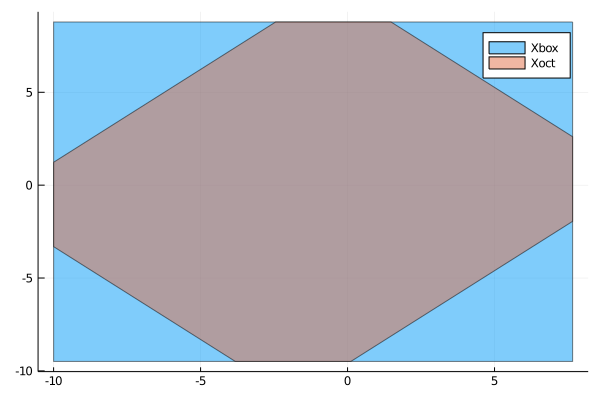

In [181]:
G = rand(Hyperplane, dim=6);
Z = rand(Zonotope, dim=6);
X = Z ∩ G

@show is_intersection_empty(Z, G)

Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

plot(Projection(Xbox, [1,2]), lab="Xbox")
plot!(Projection(Xoct, [1,2]), lab="Xoct")

In [182]:
Qbox = _overapproximate_projection_method(X, BoxDirections(dim(X)));
Qoct = _overapproximate_projection_method(X, OctDirections(dim(X)));

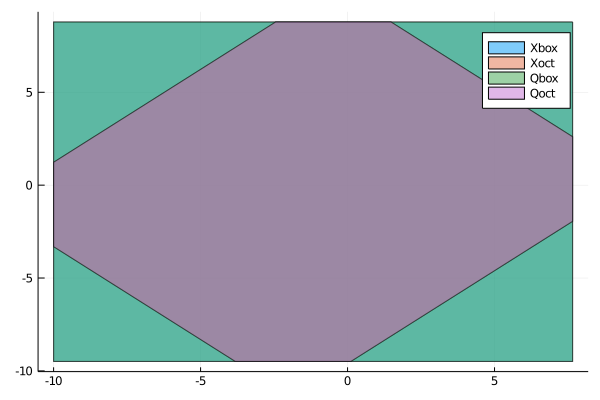

In [183]:
plot!(Projection(Qbox, [1, 2]), lab="Qbox")
plot!(Projection(Qoct, [1, 2]), lab="Qoct")

is_intersection_empty(Z, G) = false


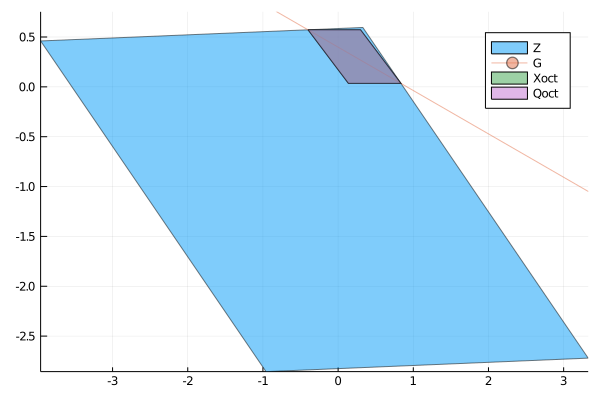

In [231]:
n = 2
G = rand(Hyperplane, dim=n);
Z = rand(Zonotope, dim=n);
X = Z ∩ G

@show is_intersection_empty(Z, G)

Xbox = overapproximate(X, BoxDirections)
Xoct = overapproximate(X, OctDirections);

plot(Z, lab="Z")
plot!(G, lab="G")

#plot(Projection(Xbox, [1,2]), lab="Xbox")
plot!(Projection(Xoct, [1,2]), lab="Xoct")

Qbox = _overapproximate_projection_method(X, BoxDirections(dim(X)));
Qoct = _overapproximate_projection_method(X, OctDirections(dim(X)))
            
#plot!(Projection(Qbox, [1, 2]), lab="Qbox")
plot!(Projection(Qoct, [1, 2]), lab="Qoct")

In [224]:
@time Xoct = overapproximate(X, OctDirections);
@time Qoct = _overapproximate_projection_method(X, OctDirections(dim(X)));

  0.287387 seconds (2.36 M allocations: 348.577 MiB, 16.75% gc time)
  1.942001 seconds (3.84 M allocations: 455.202 MiB, 5.75% gc time)


In [233]:
using LinearAlgebra

In [238]:
dot(nullspace(hcat(G.a)'), G.a)

1.1102230246251565e-16

  0.000635 seconds (6.46 k allocations: 600.328 KiB)
  0.002179 seconds (3.97 k allocations: 331.188 KiB)


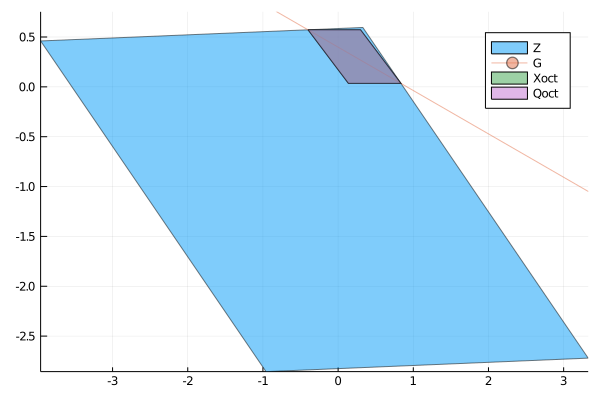

In [258]:
# we add the normal direction to the hyperplane
q = nullspace(hcat(G.a)')[:]
dirs = CustomDirections(vcat(collect(OctDirections{Float64, Vector{Float64}}(n)), [q]));

@time Xoct = overapproximate(X, dirs);
@time Qoct = _overapproximate_projection_method(X, dirs)

plot(Z, lab="Z")
plot!(G, lab="G")
plot!(Projection(Xoct, [1, 2]), lab="Xoct")
plot!(Projection(Qoct, [1, 2]), lab="Qoct")